In [20]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

from pymoo.factory import get_performance_indicator
from testsuite.utilities import Pareto_split, get_target_igd_refpoints, sigmoid
from testsuite.analysis import load_all #, plot_all_pareto_2d, PLOT_STYLE, plot_measure
from problem_setup import func, y, weighting, n_obj, n_dim

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [21]:
from testsuite import directed_optimisers 
from pymoo.factory import get_performance_indicator
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
import inspect

In [22]:
from generate_queue import targets

In [23]:
def get_target_from_str(string):
    ind = string.find('[')
    tstring = string[ind+1:-1]
    for target in targets:
        str_t = str(target).replace('.', 'p').replace(' ', '_')
        if tstring == str_t:
            return target

In [24]:
def load_result(directory):
    result = load_all(directory, trailing_text = "_results.pkl")
    name = get_name_from_dir(directory)
    result['name'] = name
    return result

def get_name_from_dir(dir_string):
    bits = dir_string.split('_')
    name = [bit for bit in bits if bit.lower() in OPTIMISER_NAMES]

    if type(name) is list:
        name = name[0]
    if 'ei' in bits:
        name+='_ei'
    elif 'mean' in bits:
        name+='_$\mu$'
    return name

In [25]:
names = ['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgo_ei', 'SmsEgo_$\\mu$', 'lhs']
true_names = ['MPoI', 'ParEGO', 'SAF: ei', 'SAF: $\mu$', 'SMS-EGO: ei', 'SMS-EGO: $\mu$', 'LHS']
D_names = {a:b for a, b in zip(names, true_names)}

In [26]:
OPTIMISER_NAMES = [cls[0].lower() for cls in inspect.getmembers(directed_optimisers, inspect.isclass)
        if cls[1].__module__ == 'testsuite.directed_optimisers' or cls[1].__module__ == 'testsuite.optimisers']

In [27]:
OPTIMISER_NAMES

['directedsaf', 'saf']

In [28]:
problem_path = './'

In [29]:
# load all results from directory tree
result_dirs = sorted(os.listdir(os.path.join(problem_path, "log_data/")))
results= []
for path in result_dirs:
    result = load_result(os.path.join(problem_path, 'log_data/',  path))
    results.append(result)
result_dirs

['WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[0p8865_3p132_]]',
 'WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[0p985_3p48_]]',
 'WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[1p0835_3p828_]]',
 'WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[1p432_1p432]]',
 'WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[1p79_1p79]]',
 'WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[1p969_1p969]]']

In [30]:
p = np.load('../../../comp/igd_refpoints/problem_refpoints/data/wfg_elipse_2d_refpoints')[::10]
p.shape

(500, 2)

In [31]:
# load all results from directory tree
result_dirs2 = ['/home/finley/phd/code/testsuite/experiments/comp/data/wfg4_2obj_6dim/log_data/WFG4_Saf_init10_MultiSurrogate_mean/']
undirected_results= []
for path in result_dirs2:
    result = load_result(os.path.join(problem_path, 'log_data/',  path))
    undirected_results.append(result)

500 1
Target:  [1.969 1.969]


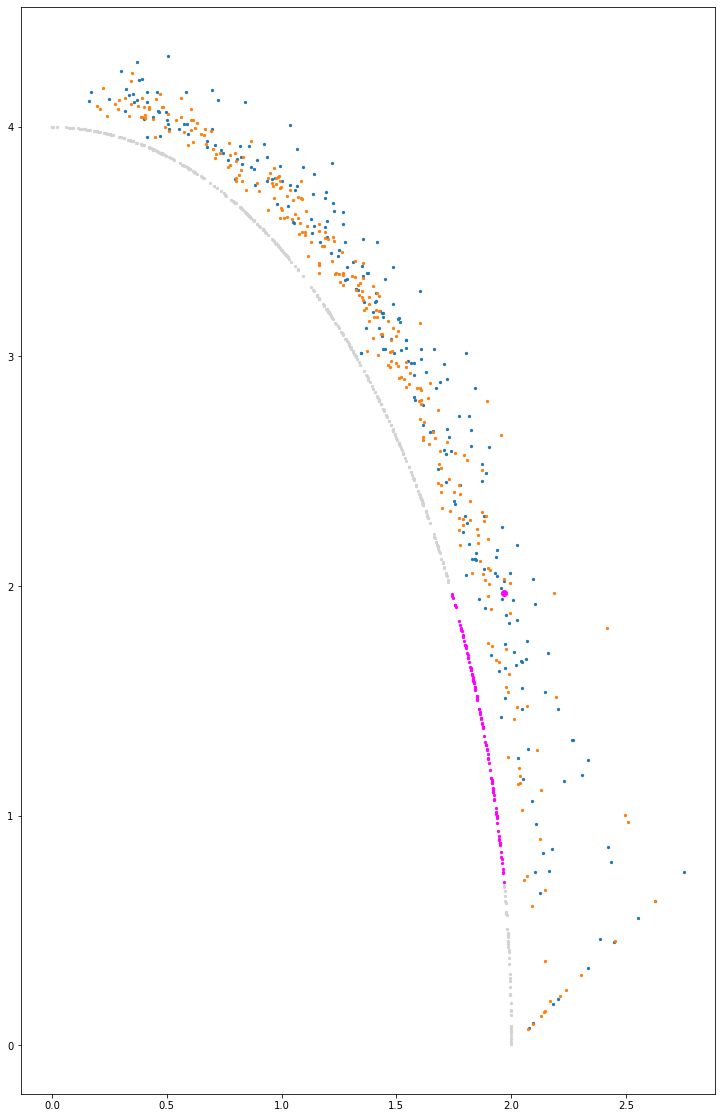

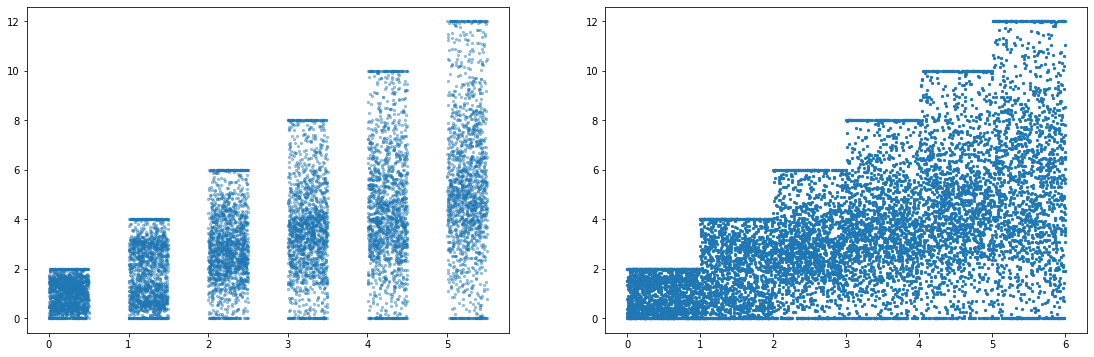

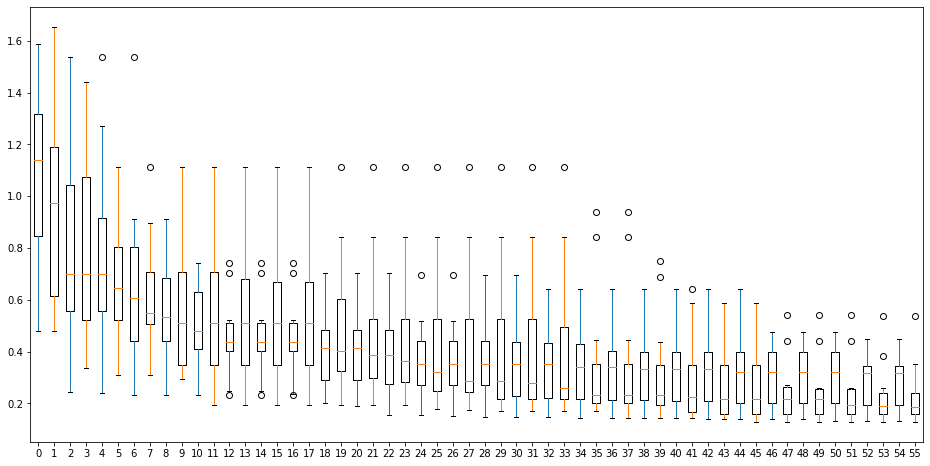

In [32]:
t_num = 5
stage=150
target = get_target_from_str(results[t_num]['log_dir'][0])
pt, pd = get_target_igd_refpoints(target, p)
print('Target: ', target)

fig0 = plt.figure(figsize=[20, 20])
fig0_ax = fig0.gca()
for i in range(11):
    pp, dd = Pareto_split(results[t_num]['y'][i][:stage])
    fig0_ax.scatter(*pp.T, c="C0", s=5)
    
for i in range(11):
    pp, dd = Pareto_split(undirected_results[0]['y'][i][:stage])
    fig0_ax.scatter(*pp.T, c="C1", s=5)
fig0_ax.scatter(*pd.T, c="lightgrey", s=5)
fig0_ax.scatter(*pt.T, c="magenta", s=5)
fig0_ax.scatter(*target.T, c="magenta")
fig0_ax.axis('scaled')

fig1 = plt.figure(figsize=[19, 6])
fig1_ax0 = fig1.add_subplot(121)
fig1_ax1 = fig1.add_subplot(122)
for i in range(11):
    pp, dd = Pareto_split(results[t_num]['y'][i][:stage], return_indices=True)
    xs = results[0]['x'][i][:stage]
    for j in range(6):
        fig1_ax0.scatter(np.ones(stage)*j+np.random.rand(stage)*0.5, xs[:,j], c="C0", s=5, alpha=0.4)

for i in range(11):
    pp, dd = Pareto_split(undirected_results[0]['y'][i][:stage], return_indices=True)
    xs = undirected_results[0]['x'][i][:stage]
    for j in range(6):
        fig1_ax1.scatter(np.ones(stage)*j+np.random.rand(stage)*10e-1, xs[:,j], c="C0", s=5)

igdp_measure = get_performance_indicator("igd+", pt)

stage_directed = []
stage_undirected = []
for stage in range(10, 150, 5):
    igdps_directed = []
    igdps_undirected = []
    for i in range(11):
        pp, dd = Pareto_split(results[t_num]['y'][i][:stage])
        igdp_directed = igdp_measure.calc(pp)
        pp, dd = Pareto_split(undirected_results[0]['y'][i][:stage])
        igdp_undirected = igdp_measure.calc(pp)
        igdps_directed.append(igdp_directed)
        igdps_undirected.append(igdp_undirected)
    stage_directed.append(igdps_directed)
    stage_undirected.append(igdps_undirected)

fig2 = plt.figure(figsize=[16, 8])
fig2_ax = fig2.gca()
fig2_ax.boxplot(stage_directed, positions=list(range(56))[::2], whiskerprops=dict(color="C0"));
fig2_ax.boxplot(stage_undirected, positions=list(range(56))[1::2], whiskerprops=dict(color="C1"));

In [33]:
    def saf(y: np.ndarray, p: np.ndarray) -> np.ndarray:
        """
        Calculates summary attainment front distances.
        Calculates the distance of n, m-dimensional points X from the
        summary attainment front defined by points P

        :param np.array p: points in the pareto front, shape[?,m]
        :param np.array y: points for which the distance to the summary
        attainment front is to be calculated, shape[n,m]

        :return np.array: numpy array of saf distances between points in
        X and saf defined by P, shape[X.shape]
        """

        D = np.zeros((y.shape[0], p.shape[0]))

        for i, p in enumerate(p):
            D[:, i] = np.max(p - y, axis=1).reshape(-1)
        Dq = np.min(D, axis=1)
        return Dq
    
def optimistic_saf(T, X):
        """
        Calculates optimmistic summary attainment front distances
        Calculates the osaf distance between the points in X and the targets defined by T

        :param T [np.array]: targetd points, shape[n,m]
        :param X [np.array]: points for which the distance to the summary attainment front is to be calculated, shape[]
        :param beta [float]: if not None, the saf distance is passed through sigmoid function with beta=squashed
        :param normalized [Bool]: if not None, the saf distance for points in X is normalized to a range from 0-1

        :return [np.array]: numpy array of saf distances between points in X and saf defined by T, shape[X.shape]
        """
        if T is None:
            Dq = np.ones(len(X))
        else:
            assert T.shape[1] == X.shape[1], "shape missmatch, {} and {}".format(T.shape, X.shape)
            D = np.zeros((X.shape[0], T.shape[0]))
            for i, p in enumerate(T):
                D[:, i] = np.min(p - X, axis=1)

            Dq = np.max(D, axis=1)
        return Dq

def osaf(y: np.ndarray, p: np.ndarray, t, w) -> np.ndarray:
        """
        Calculates summary attainment front distances.
        Calculates the distance of n, m-dimensional points X from the
        summary attainment front defined by points P

        :param np.array p: points in the attainment front, shape[?,m]
        :param np.array y: points for which the distance to the summary
        attainment front is to be calculated, shape[n,m]

        :return np.array: numpy array of saf distances between points in
        X and saf defined by P, shape[X.shape]
        """
        y = y.reshape(1, -1)
        t = t.reshape(1, -1)
        D_osaf = optimistic_saf(t, y)
        D_saf = saf(y, p)

        beta = 1.
        Dq = w*sigmoid(D_saf, beta) + (1-w)*sigmoid(D_osaf, beta)
        return Dq

In [34]:
def image_infill(f, p, t, w):
    fig = plt.figure(figsize=[8,7])
    ax = fig.gca()
    
#     compute infill
    M, N = 200, 200
    x = np.linspace(0., 3, M)
    y = np.linspace(0., 5, N)
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack((xx.flat, yy.flat)).T
    zz = np.array([osaf(xyi, p, t, w) for xyi in xy]).reshape(M, N)
    
    pcol = ax.pcolor(xx, yy, zz)
    levels = np.linspace(zz.min(), zz.max(), 20+2)[1:-1]
    ax.contour(xx, yy, zz, colors="white", levels=levels)
    
    ax.scatter(*f.T, c="w", s=5)
    ax.scatter(*p.T, c="C0", s=5)
    ax.scatter(*t.T, c="m", s=5)
    return fig

 <ipython-input-34-66f56c4eecea>:13: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


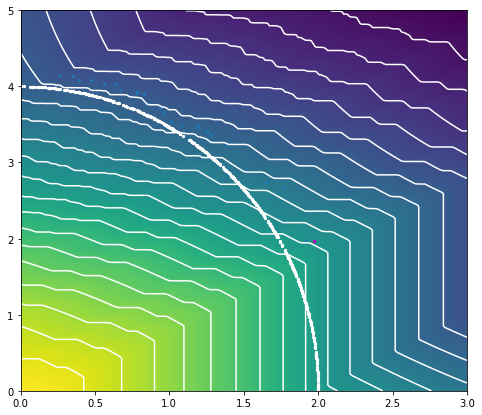

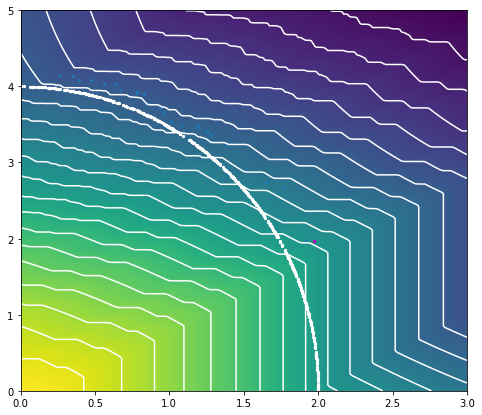

In [35]:
pp, dd = Pareto_split(results[0]['y'][i], return_indices=True)
image_infill(p, results[0]['y'][i][pp], target, 0.5)